In [1]:
import torch
from torch import nn
import json
from glob import glob
import numpy as np 
from tqdm import tqdm, trange

import matplotlib.pyplot as plt
import cv2
import os
from stacked_hourglass.model import hg2, hg8

In [2]:
def Euclidian_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def getCoordFromHeatmap(heatmap):
    # get the coordinates of the maximum value in the heatmap
    max_value = heatmap.max()
    max_value_index = np.where(heatmap == max_value)
    return max_value_index[0][0], max_value_index[1][0]

In [3]:

pth_path = 'C:/Users/USER/Downloads/Eye-Landmark-Detection-main/checkpoint_20.pth.tar'
model = hg2().cuda()
state_dict = torch.load(pth_path)['state_dict']
dict_= {k.replace('module.', ''): v for k, v in state_dict.items()}
model.load_state_dict(dict_)
test_img_list = glob('D:/IREYE4TASK/test/eye0_sub16/*.jpg')
test_json_list = glob('D:/IREYE4TASK/test/eye0_sub16/*.json')


In [17]:
dist_list = []
for i in trange(len(test_img_list[:100])):
    img_ = cv2.imread(test_img_list[i])
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (256, 256)).reshape(1, 256, 256) / 255.0
    img = torch.from_numpy(img).float().unsqueeze(0).cuda()
    output = model(img)
    orig_keypoints = json.load(open(test_json_list[i], 'r'))
    
    ratio_x = 64/640
    ratio_y = 64/480
    eyelid_x = orig_keypoints['eyelid_x']
    eyelid_x = [x*ratio_x for x in eyelid_x]
    eyelid_y = orig_keypoints['eyelid_y']
    eyelid_y = [y*ratio_y for y in eyelid_y]
    eyelid_coord = np.array([eyelid_x, eyelid_y]).T

    iris_x = orig_keypoints['iris_x']
    iris_x = [x*ratio_x for x in iris_x]
    iris_y = orig_keypoints['iris_y']
    iris_y = [y*ratio_y for y in iris_y]
    iris_coord = np.array([iris_x, iris_y]).T

    pupil_x = orig_keypoints['pupil_x']
    pupil_x = [x*ratio_x for x in pupil_x]
    pupil_y = orig_keypoints['pupil_y']
    pupil_y = [y*ratio_y for y in pupil_y]
    pupil_coord = np.array([pupil_x, pupil_y]).T
    
    orig_keypoints = np.concatenate((eyelid_coord, iris_coord, pupil_coord), axis=0)
    pred = output[0].cpu().detach().numpy()

    pred_coord = np.array([(getCoordFromHeatmap(pred[0][i])[1], getCoordFromHeatmap(pred[0][i])[0]) for i in range(28)])
    
    dist = 0
    for i in range(28):
        dist += Euclidian_distance(pred_coord[i], orig_keypoints[i])
    
    dist_list.append(dist/28) # 하나의 이미지 , 28개 키포인트에 대해  
print(np.mean(dist_list)) # 이미지 개수에 대해 mean 

100%|██████████| 100/100 [00:01<00:00, 73.65it/s]

2.010863710645212


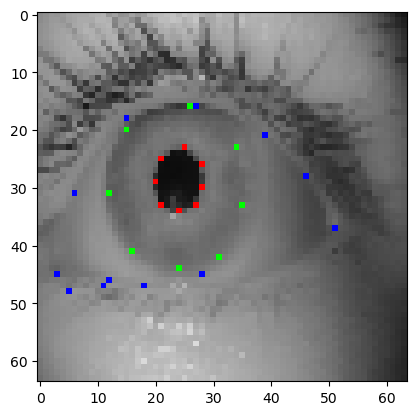

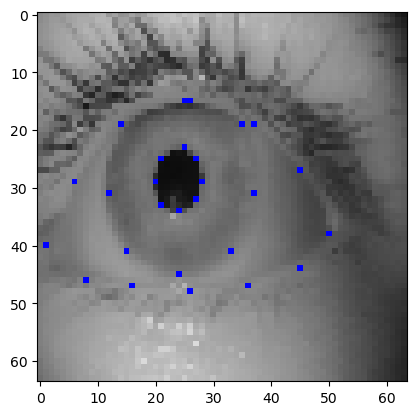

In [18]:

from stacked_hourglass.datasets.common import Dataset
import cv2
import numpy as np
import matplotlib.pyplot as plt

# dataset = Dataset('./data/train/')
# dataset_ = dataset[0]
# img_ = dataset_[0].reshape(256, 256, 3)
# output = dataset_[1]

# img_ = img_.detach().numpy()
# img_ = cv2.cvtColor(img_, cv2.COLOR_GRAY2RGB)
img_ = cv2.resize(img_, (256, 256)).reshape(256, 256, 3)
# output = output[0].detach().cpu().numpy()

im_ = cv2.resize(img_, (64, 64))
for i in range(len(pred[0])): # 28 
    tmp = pred[0][i]
    tmp_max_coord = np.where(tmp == tmp.max())
    if i <=11:
        im_[tmp_max_coord[0][0], tmp_max_coord[1][0]] = (0, 0, 255)
    elif i > 11 and i < 20:
        im_[tmp_max_coord[0][0], tmp_max_coord[1][0]] = (0, 255, 0)
    else:
        im_[tmp_max_coord[0][0], tmp_max_coord[1][0]] = (255, 0, 0)

img_ = cv2.resize(img_, (64, 64))
for i in range(len(orig_keypoints)):
    img_[int(orig_keypoints[i][1]), int(orig_keypoints[i][0])] = (0, 0, 255)
plt.imshow(im_, cmap='gray')
plt.show()
plt.imshow(img_)